# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Построим модель с максимально большим значением *accuracy*. Необходимо довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке.

# Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3214 entries, 0 to 3213

Data columns (total 5 columns):

 #   Column    Non-Null Count  Dtype  

---  ------    --------------  -----  

 0   calls     3214 non-null   float64

 1   minutes   3214 non-null   float64

 2   messages  3214 non-null   float64

 3   mb_used   3214 non-null   float64

 4   is_ultra  3214 non-null   int64  

dtypes: float64(4), int64(1)

memory usage: 125.7 KB


Обрабатывать данные не требуется, пропусков нет, тип данных в столбцах указан верно.  
У нас есть целевой признак - тип тарифа (`is_ultra`), и четыре признака.

## Разбиение данных на выборки

In [5]:
features = df.drop(['is_ultra'], axis = 1)
target = df['is_ultra']

Разделили целевой признак и объясняющие. 

In [6]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

In [7]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

In [8]:
features_train.shape

(1928, 4)

In [9]:
features_valid.shape

(643, 4)

In [10]:
features_test.shape

(643, 4)

Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3/1/1.

## Исследование моделей

DecisionTreeClassifier(max_depth=8, random_state=12345)

0.80248833592535


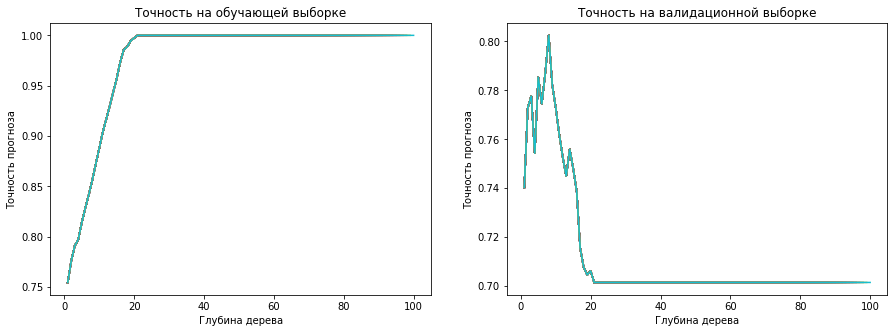

In [11]:
best_model=None
best_result=0
x = []
y_train = []
y_valid = []
fig,ax=plt.subplots(1, 2, figsize=(15,5))
for depth in range(1,101):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree.fit(features_train, target_train)
    predictions_valid=tree.predict(features_valid)
    predictions_train=tree.predict(features_train)
    result_valid = accuracy_score(target_valid, predictions_valid)
    result_train = accuracy_score(target_train, predictions_train)
    x.append(depth)
    y_train.append(result_train)
    y_valid.append(result_valid)
    ax[0].plot(x, y_train)
    ax[0].set_title('Точность на обучающей выборке')
    ax[1].plot(x, y_valid)
    ax[1].set_title('Точность на валидационной выборке')
    ax[0].set_xlabel('Глубина дерева')
    ax[0].set_ylabel('Точность прогноза')
    ax[1].set_ylabel('Точность прогноза')
    ax[1].set_xlabel('Глубина дерева') 
    if result_valid > best_result:
        best_model=tree
        best_result=result_valid
print(best_model)
print(best_result)

Для модели "Дерево решений" наилучший результат на валидационный выборке по доле правильных ответов составляет 0.802 (лучшее значение параметра max_depth = 8).

In [12]:
best_model=None
best_result=0
for est in range(1,101, 10):
    for depth in range(1,21):
        forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        forest.fit(features_train, target_train)
        predictions_valid = forest.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result:
            best_model=forest
            best_result=result
print(best_model)
print(best_result)

RandomForestClassifier(max_depth=9, n_estimators=41, random_state=12345)

0.8195956454121306


Для модели "Случайный лес" наилучший результат на валидационный выборке по доле правильных ответов составляет 0.819 (лучшее значение параметра n_estimators = 41, max_depth = 9).  
Пробовал перебирать и большие значения, результат получался на немного лучше, но обучалась модель слишком долго.

In [13]:
regression = LogisticRegression(random_state=12345, solver='lbfgs')
regression.fit(features_train, target_train)
predictions_valid = regression.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
result

0.7387247278382582

Для модели "Логистическая регрессия" наилучший результат на валидационный выборке по доле правильных ответов составляет 0.739.

Таким образом, лучшие результаты на валидационной выборке по доле правильных ответов показала модель "Случайный лес" (лучшее значение параметра n_estimators = 41, max_depth = 9).

## Проверка модели на тестовой выборке

In [14]:
forest = RandomForestClassifier(random_state=12345, n_estimators=41, max_depth=9, n_jobs=1)
forest.fit(features_train, target_train)
predictions_test = forest.predict(features_test)
result = accuracy_score(target_test, predictions_test)
result

0.8102643856920684

Таким образом, лучшей моделью является "Случайный лес", точность прогноза которой на тестовой выборке составляет 0.81

## Проверка модели на адекватность

In [15]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_test, target_test)

0.6936236391912908

DummyClassifier c параметром `strategy="most_frequent"` генерирует случайные прогнозы. Как видим точность предсказания с помощью этого метода составляет 0.695, что значительно меньше полученной лучшей модели, поэтому модель "Случайный лес" можем считать адекватной.

## Вывод

Таким образом, наиболее подходящей моделью для задачи классификации, которая выберет подходящий тариф является "Случайный лес", так как доля правильных ответов на тестовой выборке составляет 0.807, что больше, чем по остальным моделям.